-------------


GPU:True


-------------
1.3741088103166372
2.0015570338626403
2.0
1.578436529997654
2.29739670999407
2.29739670999407
tracking <tf.Variable 'ws_alpha_12:0' shape=() dtype=float32> alpha
1.8131474454755332
2.639015821545789
2.639015821545789
tracking <tf.Variable 'ws_alpha_13:0' shape=() dtype=float32> alpha
2.0827594879848212
3.0314331330207964
3.0314331330207964
tracking <tf.Variable 'ws_alpha_14:0' shape=() dtype=float32> alpha
2.392462397702631
3.482202253184497
3.482202253184497
tracking <tf.Variable 'ws_alpha_15:0' shape=() dtype=float32> alpha
2.7482176206332745
4.0
4.0
tracking <tf.Variable 'ws_alpha_16:0' shape=() dtype=float32> alpha
3.156873059995308
4.59479341998814
4.59479341998814
tracking <tf.Variable 'ws_alpha_17:0' shape=() dtype=float32> alpha
2.0
2.0
2.0
2.29739670999407
2.4622888266898326
2.4622888266898326
tracking <tf.Variable 'ws_alpha_18:0' shape=() dtype=float32> alpha
2.8284271247461903
2.8284271247461903
2.8284271247461903
tracking <tf.Variabl

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>6/2560, d1=-0.518, d2=0.907 g=0.108

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2560/2560, d1=-1378.866, d2=292.337 g=288.68742
>Saved: plot_004x004-tuned.png and model_004x004-tuned.h5


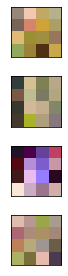

Found 160 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 8, 8, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5/5120, d1=234.645, d2=258.046 g=373.699

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5120/5120, d1=-3245911552.000, d2=951595648.000 g=959326208.000000
>Saved: plot_008x008-faded.png and model_008x008-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5/5120, d1=-2577011712.000, d2=-546066496.000 g=1100982528.000

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>5120/5120, d1=-1213745024.000, d2=-3913368064.000 g=8401162240.00000
>Saved: plot_008x008-tuned.png and model_008x008-tuned.h5


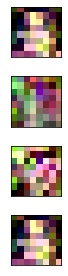

Found 160 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 16, 16, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4/10240, d1=6972026880.000, d2=-5133341696.000 g=7419737600.000

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10240/10240, d1=-167298824404992.000, d2=-316365311311872.000 g=739701547859968.00000
>Saved: plot_016x016-faded.png and model_016x016-faded.h5


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4/10240, d1=-314736847618048.000, d2=-356753472487424.000 g=552540059992064.000

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10240/10240, d1=1316959647956992.000, d2=-1326564537008128.000 g=2603668230635520.0000
>Saved: plot_016x016-tuned.png and model_016x016-tuned.h5


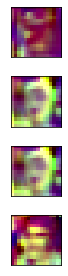

Found 160 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Scaled Data (None, 32, 32, 3)


/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4/40960, d1=3158102606086144.000, d2=-2653671313637376.000 g=1624550173310976.000

/home/pawel/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2664/40960, d1=-6125112097014546432.000, d2=-2216337814910402560.000 g=1450752816292298752.0000

In [ ]:
from progan import main
main()  